# 2.3: Nonlinear parameter estimation: Iterative Earthquake location

*Written by Andrew Valentine and Malcolm Sambridge*

<!--<badge>--><a href="https://colab.research.google.com/github/msambridge/InversionPracticals/blob/main/Solutions/S2.3 - Iterative Earthquake location-solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

In this practical, we will look at a nonlinear inverse problem that requires an iterative solution. 

As an example, we will consider is earthquake location.

Specifically, the practical is to write a python script to iteratively update an earthquake location for the $(x,y,z)$ and origin time, $t$.  Use a homogeneous crustal Earth model with wave speed, v=5.4 km/s. The tasks to be performed are:

1. Read in 10 seismic stations at locations on a +-30km box in (x,y) at the earth’s surface together with two sets of arrival times from the source to each station, one with noise added and one without.

2. Choose a random starting guess inside the box and determine expressions for each entry of the 10 x 4 Derivative matrix and build the G matrix. Build the data covariance matrix for independent Gaussian errors with $\sigma=0.2$

3. Apply the least squares iterative solution to both the noisy and noiseless data sets. Decide how many iterations to let it run for.

4. Make a plot showing the source location at each iteration for each case.

5. Make a table of the residuals vs iteration for each case.

6. Calculate and plot the model covariance matrices for each pair of parameters at your final solution.

Things to consider. Does the iterative algorithm converge to a good enough solution? Does this solution fit teh data adequately? How many iterations does it take? What happens if you put the starting solution far from the actual earthquake location? 

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !git clone https://github.com/msambridge/InversionPracticals
# %cd InversionPracticals/Solutions

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pickle
import sys
sys.path.append("../software")
import plotcovellipse as pc
import eqlocate as eq

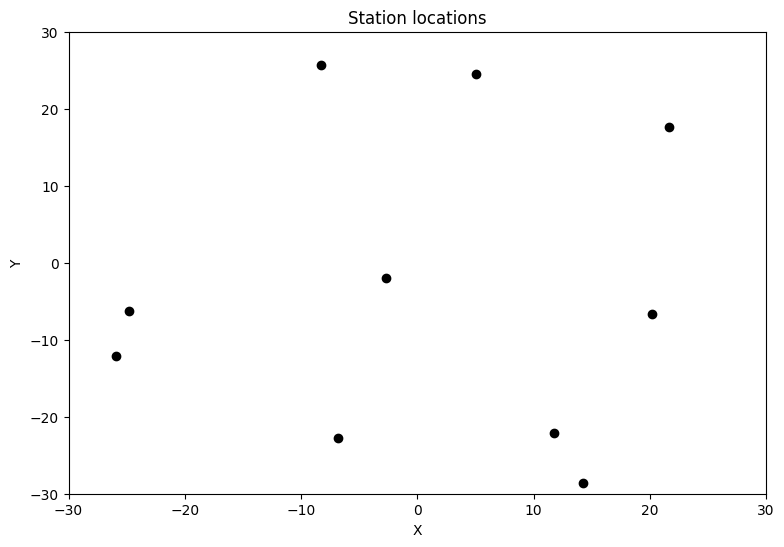

 tobs
 [ 9.31979913 10.67036112  7.91562913 11.80824099 11.13594735  9.50326285
 10.56990629 12.26874052  9.99586708  8.01971903]
 tobsn
 [ 9.14788778 10.69212619  7.90166076 11.8822169  11.07486658  9.60494135
 10.17896718 12.28384527 10.04709788  8.04154611]


In [3]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

# Read in 10 seismic stations at random locations on a +-30km box in (x,y) at the earth’s surface together 
# with two sets of arrival times from the source to each station, one with noise added and one without.

pickle_off = open("../datasets/eqdata.pickle","rb")
[tobs,tobsn,sta] = pickle.load(pickle_off)

fig, ax = plt.subplots(figsize=(9,6))
plt.title('Station locations')
ax.scatter(sta.T[0],sta.T[1],color='k')
plt.xlim(-30,30)
plt.ylim(-30,30)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(' tobs\n',tobs)
print(' tobsn\n',tobsn)

In [4]:
sta

array([[ 21.61213296,  17.58702205,   0.        ],
       [ 14.22642197, -28.63072994,   0.        ],
       [ 20.21053493,  -6.60537827,   0.        ],
       [-24.80710551,  -6.33197965,   0.        ],
       [ -8.31138626,  25.74029442,   0.        ],
       [ 11.78488761, -22.09436105,   0.        ],
       [ -6.84962065, -22.81985815,   0.        ],
       [-25.95333073, -12.16612588,   0.        ],
       [  5.04091721,  24.56018806,   0.        ],
       [ -2.7209912 ,  -2.01934734,   0.        ]])

**Task 1** First write a python function to calculate the arrival times of seismic phases at all stations.

In [5]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 


###########################
# Iterative earthquake location example 
###########################
# Build a function to calculate the arrival times of seismic phases at all stations
# 
def calct(sol,sta):
    vel = 5.4
    d = np.zeros(len(sta))     # define distance matrix shape
    for i in range(len(sta)):
        dx = sta[i,0]-sol[0]
        dy = sta[i,1]-sol[1]
        dz = sta[i,2]-sol[2]
        d[i] = np.sqrt(dx*dx+dy*dy+dz*dz)
    tpred = sol[3] + d/vel
    return tpred

xstart = [-10.0, 5.0, 5.0, 0.0]     # choose starting guess
tpred = calct(xstart,sta)
print(tpred,tobs)

[6.36875538 7.73122204 6.06424573 3.5749094  3.96318461 6.50441901
 5.26678321 4.43743521 4.66221918 2.08902684] [ 9.31979913 10.67036112  7.91562913 11.80824099 11.13594735  9.50326285
 10.56990629 12.26874052  9.99586708  8.01971903]


In [6]:
xtest = [0., 0., 0.,  0.0]
ttest = calct(xtest,sta)
print(ttest)

[5.15995062 5.92045401 3.93751236 4.74119807 5.00905181 4.63719517
 4.41216375 5.30803541 4.64299435 0.62748974]


In [7]:
r = tpred-tobs
#print(r)
chisq = np.dot(r.T,r)
print(chisq)
xstart2 = [-10.0, 5.0, 5.0, 3.0]     # choose starting guess
tpred2 = calct(xstart2,sta)
print(tpred2)
r2 = tpred2-tobs
#print(r)
chisq2 = np.dot(r2.T,r2)
print(chisq2)


302.0775241664022
[ 9.36875538 10.73122204  9.06424573  6.5749094   6.96318461  9.50441901
  8.26678321  7.43743521  7.66221918  5.08902684]
88.80588686859608


**Task 2** Now write a function to calculate the G matrix of seismic phases at all stations for any trial earthquake location.

In [8]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

###########################
# Iterative earthquake location example 
########################### 
# Build derivative matrix G. Build the data covariance matrix with sigma=0.2

def calcG(sol,sta):
    vel = 5.4
    d = np.zeros(len(sta))     # define distance matrix shape
    G = np.zeros((len(sta),4)) # define G matrix shape
    for i in range(len(sta)):
        dx = sta[i,0]-sol[0]
        dy = sta[i,1]-sol[1]
        dz = sta[i,2]-sol[2]
        d[i] = np.sqrt(dx*dx + dy*dy + dz*dz)
        G[i,0] = -dx/(d[i]*vel)
        G[i,1] = -dy/(d[i]*vel)
        G[i,2] = -dz/(d[i]*vel)
        G[i,3] = 1
    return G

xstart = [-10.0, 5.0, 5.0, 0.0]     # choose starting guess
Cdinv = np.eye(len(tobs))/(0.2*0.2)
G = calcG(xstart,sta)
print('CD inverse \n',Cdinv)
print(' G matrix at initial guess \n',G)

CD inverse 
 [[25.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 25.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 25.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 25.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 25.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 25.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 25.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 25.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 25.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 25.]]
 G matrix at initial guess 
 [[-0.17022044 -0.06777678  0.02692328  1.        ]
 [-0.10746168  0.14917657  0.02217861  1.        ]
 [-0.17084179  0.06562888  0.0282752   1.        ]
 [ 0.14204227  0.10870593  0.04796423  1.        ]
 [-0.01461162 -0.17946638  0.04326515  1.        ]
 [-0.11485748  0.14285087  0.02636173  1.        ]
 [-0.02051303  0.18114316  0.03255645  1.        ]
 [ 0.12329113  0.1326639   0.03864119  1.        ]
 [-0.1106354  -0.14387748  0.03677814  1.        ]
 [-0.11949252  0.1152299   0.08208021  1.        ]]


**Task 3** Now iteratively solve the least squares problem starting at your initial guess location and print out convergence of the solution (or divergence!). You have to choose the number of iterations.

In [9]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

###########################
# Iterative earthquake location example 
###########################
# Apply the least squares iterative solution to 
# both the noisy and noiseless data sets. Decide how many iterations to let it run for.
# 
nit = 8 # number of iterations
xsol = np.zeros([nit,4])
xstart = np.array([0,0,1.,0.])
xstart = [20.0, -6.0, 5.0, 0.0]     # choose starting guess
xsol[0,:] = xstart
t = tobs # use noiseless data for location
t = tobsn # use noisy data for location
nused =10
t = t[:nused]
Cdinv = np.eye(len(t))/(0.2*0.2)
r = []
for it in range(nit): # loop over number of iterations
    # calculate travel times of current guess
    
    tpred = calct( xsol[it],sta[:nused]) # calculate predicted travel times from current location
    G = calcG(xsol[it],sta[:nused])      # calculate new G matrix for current location
    residuals = t-tpred       # calculate residuals between observed and predicted travel times
    chisq =np.dot(residuals.T,np.dot(Cdinv,residuals))
    print(' Iteration ',it,'Chisq ',chisq,' Current location','{:7.4f} {:7.4f} {:7.4f} {:7.4f}'.format(*tuple(xsol[it])))
    r = np.append(r,residuals)
    
    A = np.dot(np.transpose(G), Cdinv)
    GtG = np.dot(A, G) # G^T C_inv G^T
    GtGinv = np.linalg.inv(GtG) # Inverse of G^TC_inv G
    B = np.dot(GtGinv,A) # Least squares operator 
    dm = np.dot(B,residuals) # find update to location solution  
    if(it!=nit-1):xsol[it+1] = xsol[it] + dm
r = r.reshape(nit,len(sta[:nused]))
xsoln = np.copy(xsol)

 Iteration  0 Chisq  5698.886175973503  Current location 20.0000 -6.0000  5.0000  0.0000
 Iteration  1 Chisq  101.2863285822325  Current location  8.7195  0.5279 12.4840  5.4061
 Iteration  2 Chisq  4.825727982003634  Current location 10.1895 -0.0320 10.8207  4.9080
 Iteration  3 Chisq  4.772001229610371  Current location 10.1403 -0.0014 10.7237  4.9037
 Iteration  4 Chisq  4.7719999577339305  Current location 10.1409 -0.0017 10.7242  4.9036
 Iteration  5 Chisq  4.771999957643578  Current location 10.1409 -0.0017 10.7242  4.9036
 Iteration  6 Chisq  4.771999957643567  Current location 10.1409 -0.0017 10.7242  4.9036
 Iteration  7 Chisq  4.771999957643581  Current location 10.1409 -0.0017 10.7242  4.9036


**Task 4** Make a plot of the convergence of the solution in the (x,y) plane.

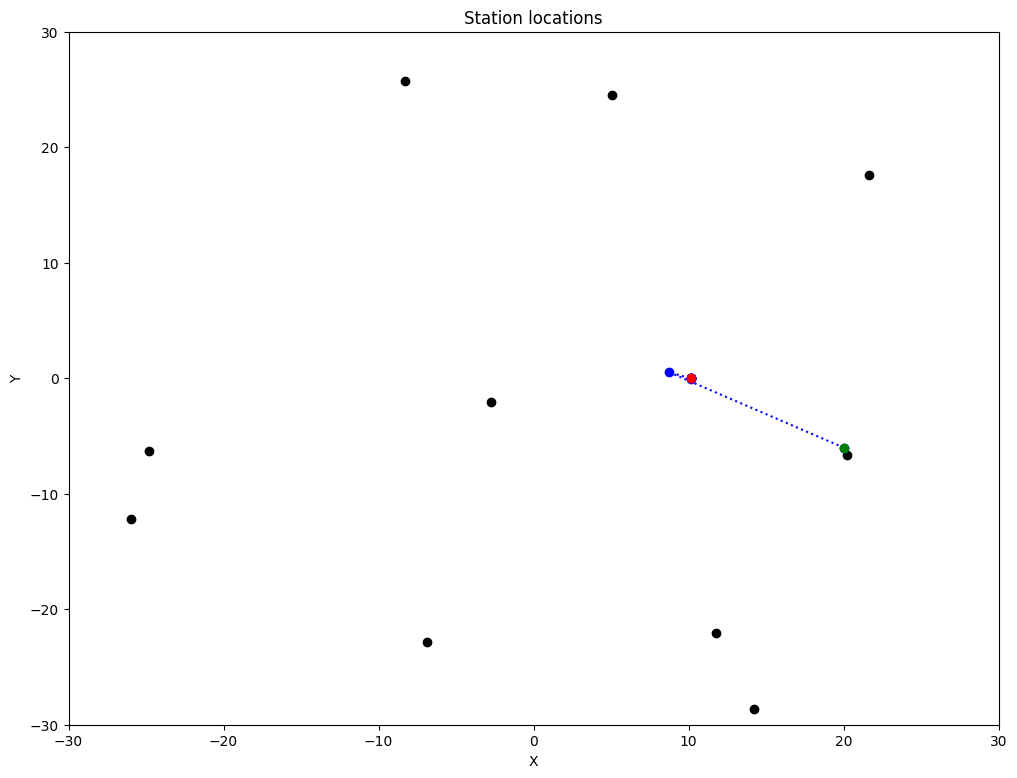

In [10]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

###########################
# Iterative earthquake location example 
###########################
# Make a plot showing the source location at each iteration for each case.

fig, ax = plt.subplots(figsize=(12,9))
plt.title('Station locations')
ax.scatter(sta.T[0],sta.T[1],color='k')
#plt.plot(xsol.T[0][:nit],xsol.T[1][:nit],'go:') # plot convergence of noiseless solution
#plt.plot(xsol.T[0][-1],xsol.T[1][-1],'ro')    
plt.plot(xsoln.T[0][:nit],xsoln.T[1][:nit],'bo:') # plot convergence of noisy solution
plt.plot(xsoln.T[0][-1],xsoln.T[1][-1],'ro')
plt.plot(xsoln.T[0][0],xsoln.T[1][0],'go')
plt.xlim(-30,30)
plt.ylim(-30,30)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

**Task 5** Make a table of arrival time residuals for each iteration.

In [11]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

###########################
# Iterative earthquake location example 
###########################
# Make a table of the residuals vs iteration for each case.

print('\nStation arrival time residuals for each iteration\n')
print('         ',('{:7d} '*nit).format(*range(nit)))
for i in range(len(sta)):
   print('Station ',i,('{:7.4f} '*nit).format(*tuple(r.T[i])))



Station arrival time residuals for each iteration

                0       1       2       3       4       5       6       7 
Station  0  4.6729 -0.8434 -0.1346 -0.1223 -0.1222 -0.1222 -0.1222 -0.1222 
Station  1  6.2690 -0.6756  0.0725  0.0766  0.0767  0.0767  0.0767  0.0767 
Station  2  6.9682 -0.9129  0.0035  0.0118  0.0119  0.0119  0.0119  0.0119 
Station  3  3.5329 -0.2696  0.0910  0.1082  0.1081  0.1081  0.1081  0.1081 
Station  4  3.1443 -0.4214 -0.0405 -0.0211 -0.0211 -0.0211 -0.0211 -0.0211 
Station  5  6.1329 -0.6195  0.1368  0.1432  0.1434  0.1434  0.1434  0.1434 
Station  6  4.2391 -0.9149 -0.3664 -0.3549 -0.3549 -0.3549 -0.3549 -0.3549 
Station  7  3.6479 -0.3401  0.0367  0.0525  0.0525  0.0525  0.0525  0.0525 
Station  8  3.6785 -0.4201  0.0731  0.0913  0.0912  0.0912  0.0912  0.0912 
Station  9  3.6707 -0.5356 -0.0076  0.0144  0.0143  0.0143  0.0143  0.0143 


**Task 6** Perform a goodness of fit test to see if the data fit is satisfactory. Calculate the 5%, 50%, and 95% critical values and the p value for the best fit.

In [12]:
# Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

########################
#  Goodness of fit 
########################
ndata=len(tobs)
mls =xsoln[-1]
G = calcG(xsoln[-1],sta)

r = t - calct( mls,sta) # calculate residuals
A = np.dot(np.transpose(r), Cdinv)
chisq = np.dot(A, r) # Calculate Chi-square
crit5 = stats.chi2.ppf(q=0.05,df=ndata-4) # Critical value for 5% C.I.
crit50= stats.chi2.ppf(q=0.5,df=ndata-4) # Critical value for 50% C.I.
crit95= stats.chi2.ppf(q=0.95,df=ndata-4) # Critical value for 95% C.I.
p_value = 1 - stats.chi2.cdf(x=chisq,df=ndata-4) # Find the p-value

print("\nChi-square value: {:10.6f}".format(chisq))
print("Critical values for Chi-square")
print("  5% {:7.3f} \n 50% {:7.3f} \n 95% {:7.3f} \n".format(crit5,crit50,crit95))
#p_value = 1 - stats.chi2.cdf(x=chisq,  # Find the p-value
#                             df=ndata-3)
print(" P value for observed Chi-square: {:7.4f} \n".format(p_value))


Chi-square value:   4.772000
Critical values for Chi-square
  5%   1.635 
 50%   5.348 
 95%  12.592 

 P value for observed Chi-square:  0.5734 



**Task 7** Calculate and plot the model covariance matrices for each pair of parameters at your final solution in the (x,y),(x,z),(y,z) and (z,t) planes. Do you see any significant trade-offs between the errors here?

In [13]:
### Try it here! You can insert more cells by selecting Cell > Insert Cell Above/Below from the menu
# bar, or by pressing Esc to enter command mode and then hitting A or B (for above/below). 

mls =xsoln[-1]
G = calcG(xsoln[-1],sta)
A = np.dot(np.transpose(G), Cdinv)
GtG = np.dot(A, G) # G^T C_inv G^T
Cm = np.linalg.inv(GtG) # Covariance matrix of solution errors
    
print("Covariance matrix\n",Cm)

D = np.sqrt(np.diag(Cm)) 
Dinv = np.linalg.inv(np.diag(D))
Corr = np.dot(Dinv,np.dot(Cm,Dinv)) #  Correlation matrix of solution errors
print("\nCorrelation matrix\n",Corr)

sig_param1 = np.sqrt(Cm[0,0])
sig_param2 = np.sqrt(Cm[1,1])
sig_param3 = np.sqrt(Cm[2,2])
sig_param4 = np.sqrt(Cm[3,3])
print("\n Solution and 95% Confidence intervals ")
print(" X {:7.3f} [{:7.3f}, {:7.3f}]".format(mls[0],mls[0]-1.96*sig_param1,mls[0]+1.96*sig_param1))
print(" Y {:7.3f} [{:7.3f}, {:7.3f}]".format(mls[1],mls[1]-1.96*sig_param2,mls[1]+1.96*sig_param2))
print(" Z {:7.3f} [{:7.3f}, {:7.3f}]".format(mls[2],mls[2]-1.96*sig_param3,mls[2]+1.96*sig_param3))
print(" T {:7.3f} [{:7.3f}, {:7.3f}]".format(mls[3],mls[3]-1.96*sig_param4,mls[3]+1.96*sig_param4))


Covariance matrix
 [[ 5.26780684e-01 -5.71729022e-03  1.08402323e+00 -1.08903996e-01]
 [-5.71729022e-03  2.68020794e-01 -6.48852485e-02 -5.13222619e-04]
 [ 1.08402323e+00 -6.48852485e-02  9.19884647e+00 -7.60497785e-01]
 [-1.08903996e-01 -5.13222619e-04 -7.60497785e-01  6.79297752e-02]]

Correlation matrix
 [[ 1.         -0.01521567  0.49244415 -0.57570341]
 [-0.01521567  1.         -0.0413233  -0.00380357]
 [ 0.49244415 -0.0413233   1.         -0.96205783]
 [-0.57570341 -0.00380357 -0.96205783  1.        ]]

 Solution and 95% Confidence intervals 
 X  10.141 [  8.718,  11.563]
 Y  -0.002 [ -1.016,   1.013]
 Z  10.724 [  4.780,  16.669]
 T   4.904 [  4.393,   5.414]


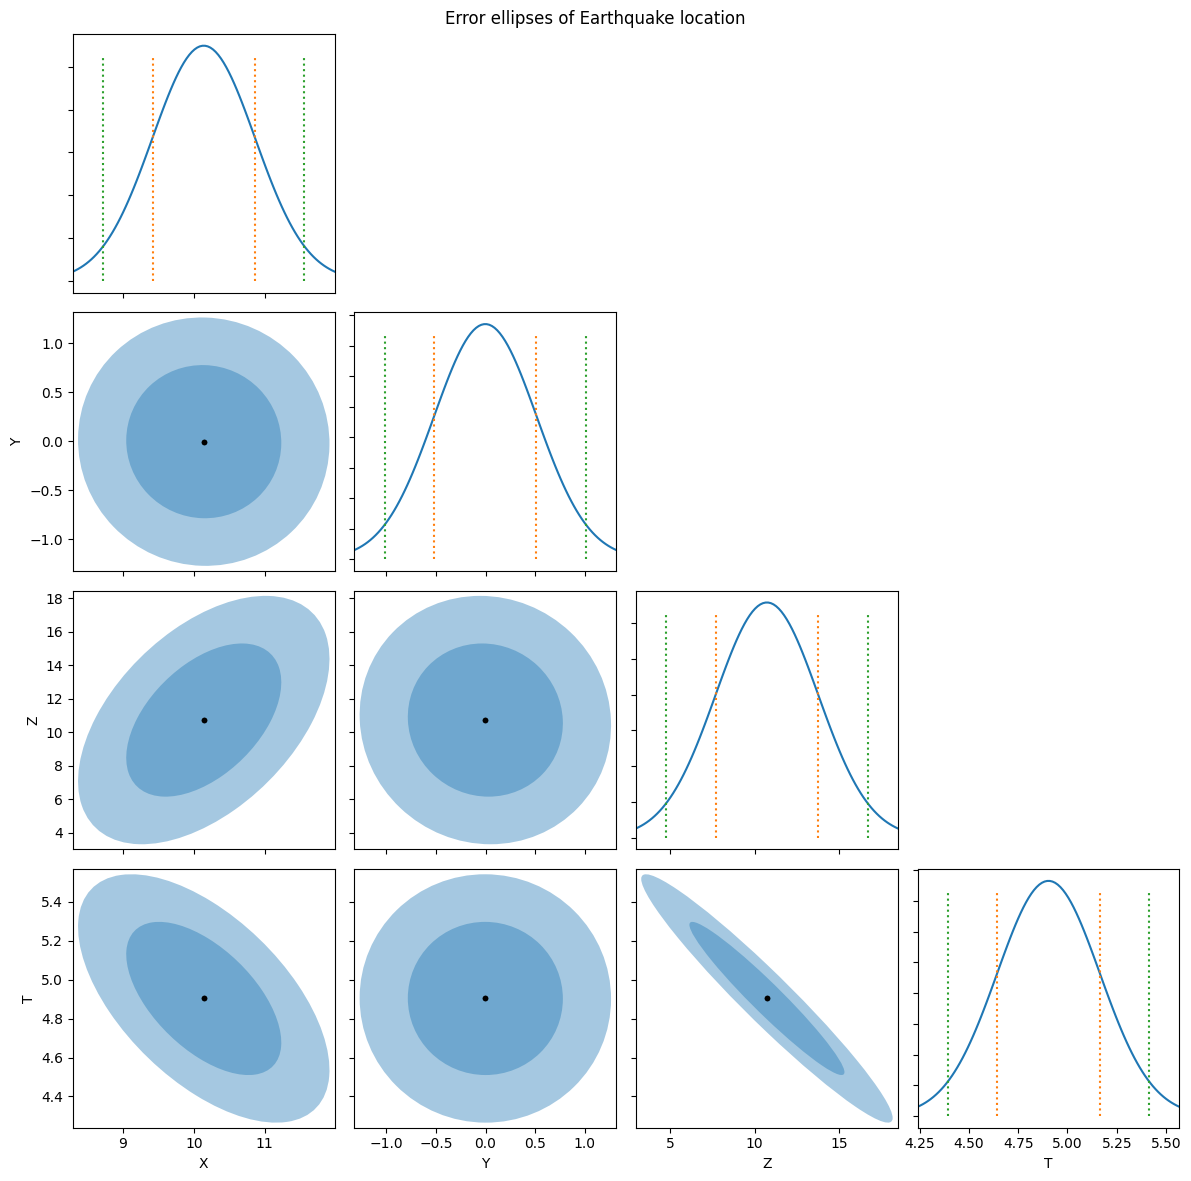

In [14]:
pc.gaussian_corner(Cm,mls,title='Error ellipses of Earthquake location',labels=['X','Y','Z','T'],figsizex=12,figsizey=12)

----